In [1]:
import sys
sys.path.append('/Users/Ralph/Desktop/astro/45500')
from sklearn.cross_validation import train_test_split
from MLPipeline.IO.config_parser import parse_configfile
from MLPipeline.IO.collect_classes import get_two_classes
from MLPipeline.gridsearch._tools import build_parameter_grid, grid_search
from sklearn.pipeline import Pipeline
import time
%matplotlib inline

/Users/Ralph/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load the data and the labels
X, y = get_two_classes('/Users/Ralph/Desktop/astro/45500/LSST/~avestruz/LSST/nonlens/*', '/Users/Ralph/Desktop/astro/45500/LSST/~avestruz/LSST/lens/*')

In [3]:
# Split the dataset and labels into training and testing subsets (collect first 100, which are non-lens,
# and last hundred, which are lens)                                                
X_train, X_test, y_train, y_test = train_test_split( X[:100]+X[-100:], y[:100]+y[-100:], test_size=0.2 )

In [4]:
# Build the estimators and feed into the pipeline      
from sklearn.linear_model import LogisticRegression
from MLPipeline.features.feature_extraction import HOG
feature_selection = [('hog', HOG())]
classifier = [('logistic_regression', LogisticRegression())]

estimators = feature_selection+classifier

pipeline = Pipeline(estimators)

pipeline.fit(X_train, y_train)

pipeline.predict(X_test)


/Users/Ralph/anaconda/lib/python2.7/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


array([1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1])

In [5]:
# Create the grid search with list of parameters                                                             
# to search                                                                                                  
param_grid = [{'hog__orientations' : (4, 5,),
                'hog__pixels_per_cell' : ((4, 4),),
                'hog__cells_per_block' : ((2, 2),),
                'logistic_regression__C' : (1.,10.),
                }]


In [6]:
# Compose a grid search from the extimators in the pipeline and the corresponding grid parameters
from sklearn.grid_search import GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid,
                               n_jobs = -1)

/Users/Ralph/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [7]:
# Run the grid search on the training set
start_time = time.time()
grid_search.fit(X_train,y_train)
print "Time Taken: ", time.time() - start_time

Time Taken:  2.76754999161


In [8]:
# Take a look at the best score
grid_search.best_score_

0.59375

In [9]:
# Take a look at the parameters that output the best score
grid_search.best_params_

{'hog__cells_per_block': (2, 2),
 'hog__orientations': 5,
 'hog__pixels_per_cell': (4, 4),
 'logistic_regression__C': 10.0}

In [10]:
# Short function to print the confusion matrix for predicted scores
def confusion_matrix(predicted, actual):
    '''                                                                                                          
    | Outputs (what model thinks it is, what it is) 
    
    '''
    import numpy as np
    from collections import Counter
    predicted, actual = map(np.array, [predicted, actual])
    return Counter(zip(predicted, actual))


In [11]:
# Show score for training set and test set using best parameters                                                          
print 'Train score:', grid_search.score(X_train, y_train)
print 'Test score:', grid_search.score(X_test, y_test)

Train score: 1.0
Test score: 0.65


In [12]:
# Show confusion matrix for test set using best parameters
print 'train matrix', confusion_matrix(grid_search.predict(X_train), y_train)
print 'test matrix', confusion_matrix(grid_search.predict(X_test), y_test)

train matrix Counter({(0, 0): 81, (1, 1): 79})
test matrix Counter({(0, 0): 14, (1, 1): 12, (0, 1): 9, (1, 0): 5})


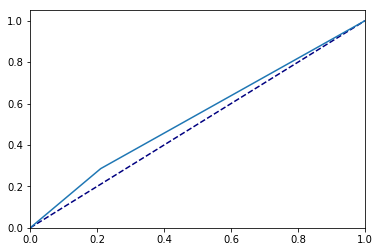

In [13]:
#Plotting ROC Curve
import numpy as np
from sklearn import metrics



fpr,tpr,threshold=metrics.roc_curve(y_test, pipeline.predict(X_test))


from matplotlib import pyplot as plt
x=fpr
y=tpr
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.plot(x,y)



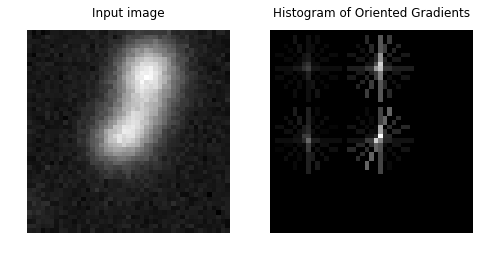

In [14]:
#visulization of HOG
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, color, exposure

image = X_train[7]

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')


ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box-forced')
plt.show()

Methodology

The study of whether an object is lensed or unlensed is a binary classification problem. To achieve our goal of distinguishing between lensed and unlensed objects, we choose the Logistic Regression classifier here because of its accuracy and efficiency when it comes to binary classification, and also because we do not expect the classification result to be anything more than a linear class boundary. Logistic Regression classifier fits a linear model to our training dataset and gives out each input test data's probability of belonging to one of the labels. To find the parameter that gives the best prediction, we use grid search to find out the best C value - we train a set of models that differ from each other in their parameter values, which lie on a grid, and evaluate them using test data to find which model gives the most accurate predictions.

To build a model, we select only the most valuable and accessible features of the input images. In our case, we want to use the distribution (histograms) of directions of gradients (oriented gradients) as our feature. Gradients (x and y derivatives) of an image are useful because the magnitude of gradients is large around edges and corners (regions of abrupt intensity changes), and edges and corners pack in a lot more information about object shape than flat regions (object shape is important in determining if an object is lensed or unlensed). HOG works in the following way: the algorithm finds the magnitude (which fires whereever there is a sharp change in intensity) and direction of gradient at every pixel; then it creates a histogram of gradients on a smaller patch containing certain amount of pixels - a bin is selected based on the direction, and then the vote (the value that goes into the bin) is selected based on the magnitude. However, gradients of an image are sensitive to overall lighting. For example, if the image is made darker by dividing all pixel values by 2, the gradient magnitude will change by half, and therefore the histogram values will change by half. This is why we want our descriptor to be independent of lighting variations, i.e. we would like to normalize the histogram so they are not affected by variations.
